In [1]:
import ast 
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt


# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#data cleanup
df['job_posted_date']=pd.to_datetime(df['job_posted_date'])
df['job_skills']=df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)  # This converts the string representation to an actual list

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785741 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   job_title_short        785741 non-null  object        
 1   job_title              785740 non-null  object        
 2   job_location           784696 non-null  object        
 3   job_via                785733 non-null  object        
 4   job_schedule_type      773074 non-null  object        
 5   job_work_from_home     785741 non-null  bool          
 6   search_location        785741 non-null  object        
 7   job_posted_date        785741 non-null  datetime64[ns]
 8   job_no_degree_mention  785741 non-null  bool          
 9   job_health_insurance   785741 non-null  bool          
 10  job_country            785692 non-null  object        
 11  salary_rate            33067 non-null   object        
 12  salary_year_avg        22003 non-null   floa

In [3]:
#filter for Data Analyst roles only
df_DA= df[df['job_title_short'] == 'Data Analyst']

### customizing our chart from `12_exercise_trending_skills.ipynb`

C:\Users\go\AppData\Local\Temp\ipykernel_3872\813602876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month


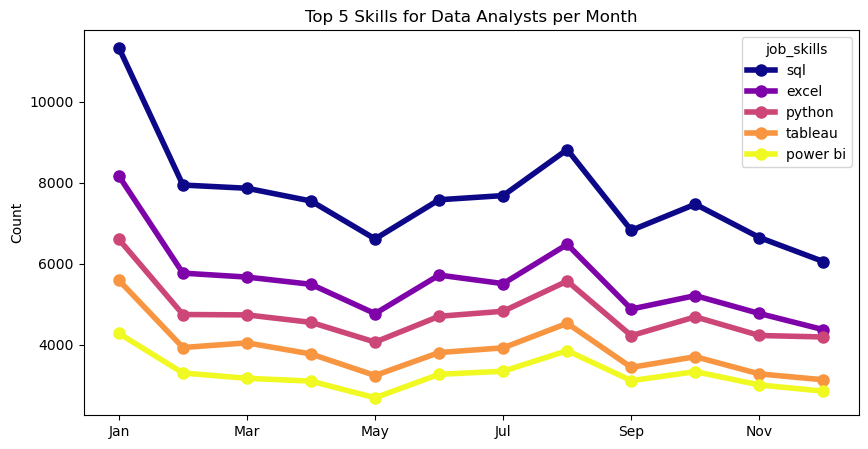

In [4]:
# creat a new column for month number
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

# explode the job_skills and pivot
df_DA_explode = df_DA.explode('job_skills')
df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills', aggfunc='size', fill_value=0)

# sort skills by count
df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

# use month name for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

# get the top 5 skills for Data Analysts
df_DA_pivot.iloc[:, :5].plot(
    kind='line',
    linewidth=4,
    #linestyle=':', # options: '-', '--', '-.', ':'
    colormap='plasma', # options: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
    markersize=8,
    marker='o', # options: 'o', 'x', '+', '*', '.', ',', 's', 'p', 'h', 'H', '1', '2', '3', '4', ...
    figsize=(10, 5),
)

plt.title('Top 5 Skills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

### customizing our scatter plot from `15_matplotlib_scatter_plot`

0 sql
1 python
2 aws
3 azure
4 r
5 tableau
6 excel
7 spark
8 power bi
9 java
10 sas
11 hadoop
12 scala
13 snowflake
14 databricks
15 gcp
16 git
17 kafka
18 airflow
19 oracle


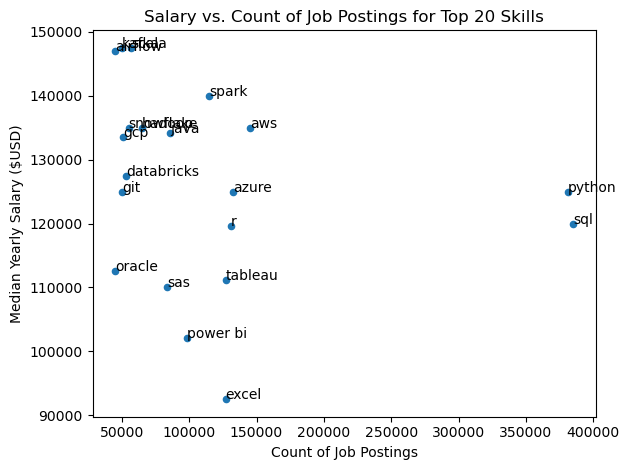

In [5]:
# explode the job_skills into separate rows
df_exploded = df.explode('job_skills')

# calculate the avrage salary per year and count of job postings for each skill
skill_stats = df_exploded.groupby('job_skills') .agg(
    skill_count=('job_skills', 'count'),
    median_salary=('salary_year_avg', 'median')
)

# limit to top 10 skills by count
skill_count = 20
skills_stats = skill_stats.sort_values(by='skill_count', ascending=False).head(skill_count)
skills_stats

# plotting
skills_stats.plot(kind='scatter', x='skill_count', y='median_salary')
plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title('Salary vs. Count of Job Postings for Top 20 Skills')
plt.tight_layout()

for i, txt in enumerate(skills_stats.index): # Add skill names as text labels
    print(i, txt)
    plt.text(x= skills_stats['skill_count'].iloc[i], y= skills_stats['median_salary'].iloc[i], s= txt) # the text() format takes x, y, text as arguments

plt.show()

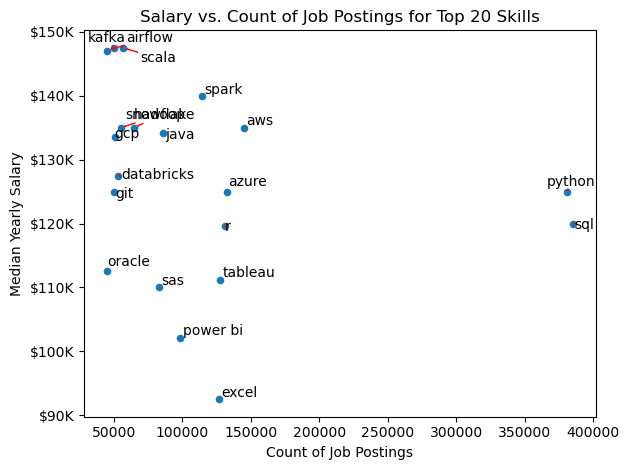

In [6]:
from adjustText import adjust_text

# Plot scatter for top skills

# fig, ax = plt.subplots()  # create a figure and axis object
ax = skills_stats.plot(kind='scatter', x='skill_count', y='median_salary')

texts = []
for i, txt in enumerate(skills_stats.index):  # use skills_stats, not skill_stats
    texts.append(
        plt.text(skills_stats['skill_count'].iloc[i],
                 skills_stats['median_salary'].iloc[i],
                 txt)
    )

# Adjust overlapping labels
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Format y-axis as $K
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${y/1000:.0f}K'))

# Set axis labels, title
plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary')
plt.title(f'Salary vs. Count of Job Postings for Top {skill_count} Skills')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()